In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import torch

from tqdm import tqdm
from pathlib import PurePath

import vxs

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__



## Durations of samples in autoencoder training data

In [2]:
vocal_sketch_dataset = vxs.SimpleSampleSet(glob.glob(
    '../data/vocal-sketch/interactiveaudiolab-VocalSketchDataSet-6c9f381/vocal_imitations/included/*.wav'))
drum_machines_dataset = vxs.SimpleSampleSet(glob.glob('../data/200-drum-machines/drums/*/*.wav'))
avp_personal_dataset = vxs.SimpleSampleSet(glob.glob('../data_temp/avp-cut/personal/*/*.wav'))
avp_fixed_dataset = vxs.SimpleSampleSet(glob.glob('../data_temp/avp-cut/fixed/*/*.wav'))
bbs1_samples = vxs.SimpleSampleSet(glob.glob('../data_temp/beatboxset1/DR/*/*.wav'))
print(f'vocal sketch: {len(vocal_sketch_dataset)} samples')
print(f'200 drum machines: {len(drum_machines_dataset)} samples')
print(f'AVP personal hits: {len(avp_personal_dataset)}')
print(f'Beatboxset1: {len(bbs1_samples)}')

vocal sketch: 4429 samples
200 drum machines: 6749 samples
AVP personal hits: 2875
Beatboxset1: 2317


In [3]:
def fetch_durations(dataset):
    durations = []
    for i in tqdm(range(len(dataset))):
        track = dataset.tracks[i]
        durations.append(track.duration*1000)
    return np.array(durations)

In [4]:
avp_durations = fetch_durations(avp_personal_dataset)

100%|██████████| 2875/2875 [01:25<00:00, 33.60it/s]


In [5]:
np.min(avp_durations)

83.78684807256235

In [6]:
np.max(avp_durations)

5845.62358276644

In [7]:
np.mean(avp_durations)

433.3660416050479

In [8]:
np.median(avp_durations)

471.7006802721088

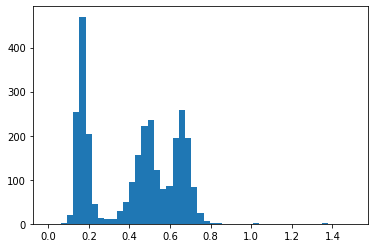

In [9]:
plt.hist(avp_durations/1000, bins=np.linspace(0, 1.5, 50))
plt.show()

In [10]:
avf_durations = fetch_durations(avp_fixed_dataset)

100%|██████████| 3317/3317 [01:50<00:00, 29.92it/s]


In [11]:
np.median(avf_durations)

468.70748299319723

In [13]:
np.mean(avf_durations)

456.01734895546

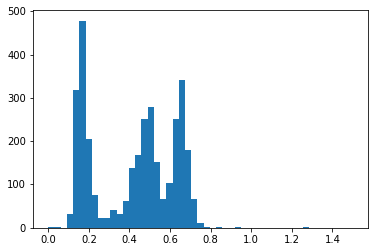

In [12]:
plt.hist(avf_durations/1000, bins=np.linspace(0, 1.5, 50))
plt.show()

In [21]:
bbs1_durations = fetch_durations(bbs1_samples)

100%|██████████| 2317/2317 [00:07<00:00, 301.27it/s]


In [22]:
np.min(bbs1_durations), np.max(bbs1_durations)

(32.44897959183673, 1883.2879818594104)

In [23]:
np.mean(bbs1_durations), np.median(bbs1_durations)

(178.99231452039885, 159.97732426303853)

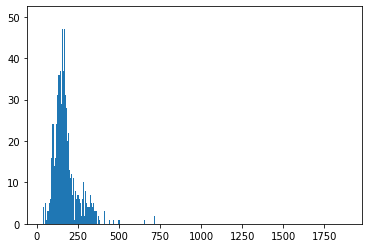

In [24]:
plt.hist(bbs1_durations, bins=1000)
plt.show()

In [8]:
vocal_durations = fetch_durations(vocal_sketch_dataset)

100%|██████████| 4429/4429 [00:01<00:00, 2306.67it/s]


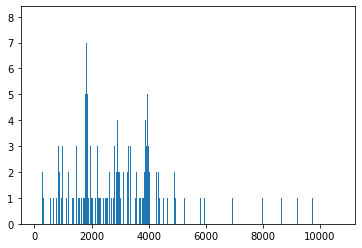

In [9]:
plt.hist(vocal_durations, bins=int(vocal_durations.max() - vocal_durations.min()))
plt.show()

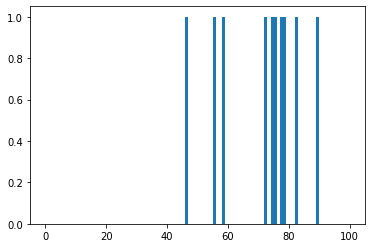

In [10]:
plt.hist(vocal_durations, bins=100, range=(0, 100))
plt.show()

In [14]:
drum_durations = fetch_durations(drum_machines_dataset)

100%|██████████| 6749/6749 [00:18<00:00, 373.21it/s] 


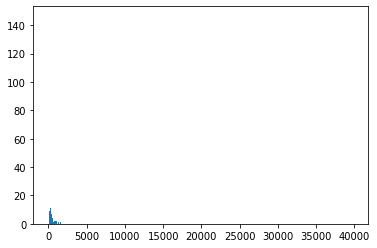

In [15]:
plt.hist(drum_durations, bins=int(drum_durations.max() - drum_durations.min()))
plt.show()

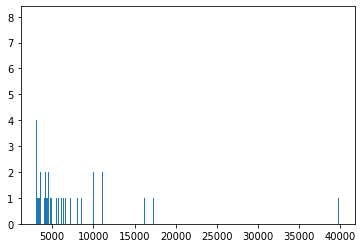

In [16]:
plt.hist(drum_durations, range=(3000, 40000), bins=1000)
plt.show()

## AVP Dataset segments durations stats

The following code has been used for determining inaccurate ground truth onsets in AVP Dataset

In [2]:
avp_set_fixed = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset/', subset='Fixed')
avp_set_personal = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset', subset='Personal')
fixed_segments = vxs.SegmentSet(avp_set_fixed, frame_window=None)
personal_segments = vxs.SegmentSet(avp_set_personal, frame_window=None)

In [18]:
def min_max_segm_lens(segments):
    min_segm_lens = dict((cl, 100000) for cl in ['kd', 'sd', 'hhc', 'hho'])
    for segm, cl in segments:
        min_segm_lens[cl] = min(min_segm_lens[cl], segm.n_samples)
    
    max_segm_lens = dict((cl, 0) for cl in ['kd', 'sd', 'hhc', 'hho'])
    for segm, cl in fixed_segments:
        max_segm_lens[cl] = max(max_segm_lens[cl], segm.n_samples)
        
    return min_segm_lens, max_segm_lens

def diff_table(ds):
    df = pd.DataFrame(columns=['track', 'min_diff', 'max_diff', 'duration'])
    for track, anno in ds.annotated_tracks():
        times = np.concatenate((anno['time'].values, [track.duration]))
        diffs = times[1:] - times[:-1]
        t_name = PurePath(track.filepath).stem 
        df.loc[len(df)] = [t_name, diffs.min(), diffs.max(), track.duration]
    return df

In [19]:
min_max_segm_lens(fixed_segments)

({'kd': 3839, 'sd': 4287, 'hhc': 1400, 'hho': 2169},
 {'kd': 579120, 'sd': 581744, 'hhc': 628327, 'hho': 580672})

In [20]:
min_max_segm_lens(personal_segments)

({'kd': 3695, 'sd': 3823, 'hhc': 3615, 'hho': 3071},
 {'kd': 579120, 'sd': 581744, 'hhc': 628327, 'hho': 580672})

In [23]:
diff_table(avp_set_fixed)

,track,min_diff,max_diff,duration
0,P27_Improvisation_Fixed,0.120816,0.775692,20.494512
1,P27_HHopened_Fixed,0.159365,0.691429,9.896780
2,P27_Kick_Fixed,0.132789,0.675918,9.943220
3,P27_Snare_Fixed,0.160000,0.657778,9.687800
4,P27_HHclosed_Fixed,0.156372,0.667211,9.827120
...,...,...,...,...
135,P3_HHopened_Fixed,0.140771,0.672653,9.975828
136,P3_Kick_Fixed,0.119546,0.682630,10.036825
137,P3_HHclosed_Fixed,0.157823,0.693878,10.518639
138,P3_Snare_Fixed,0.148753,0.686803,10.460590


In [24]:
diff_table(avp_set_personal)

,track,min_diff,max_diff,duration
0,P27_Improvisation_Personal,0.125533,0.682812,21.251451
1,P27_Snare_Personal,0.141678,0.699864,10.123900
2,P27_HHopened_Personal,0.125170,0.714195,9.884082
3,P27_HHclosed_Personal,0.151474,0.685714,10.987392
4,P27_Kick_Personal,0.140771,0.694785,11.122358
...,...,...,...,...
120,P3_HHopened_Personal,0.145669,0.697415,9.797370
121,P3_Improvisation_Personal,0.203356,0.691338,19.747120
122,P3_Snare_Personal,0.165986,0.704762,12.450249
123,P3_Kick_Personal,0.140771,0.676281,11.045442


### t-SNE features visualisation

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [7]:
avp_segments_fixed = vxs.SimpleSampleSet(glob.glob('../data_temp/avp-cut/fixed/*/*.wav'))
print(len(avp_segments_fixed))
avp_segments_personal = vxs.SimpleSampleSet(glob.glob('../data_temp/avp-cut/personal/*/*.wav'))
print(len(avp_segments_personal))

3317
2875


In [8]:
def fetch_samples(ds, n_per_class=30, random_seed=42):
    np.random.seed(random_seed)
    X, y = ds.tracks, ds.classes
    idxs = np.arange(len(X))
    shuffle_idxs = []
    classes = np.unique(y)
    for cl in classes:
        shuffle_idxs += list(np.random.choice(idxs[y == cl], size=n_per_class))

    return X[shuffle_idxs], y[shuffle_idxs]

def tsne_features_visualize(f_transform, X, y, **kwargs):
    classes = np.unique(y)
    tsne = TSNE(**kwargs)
    X_feat = StandardScaler().fit_transform(f_transform.fit_transform(X))
    X_tsne = tsne.fit_transform(X_feat)
    
    colormap = dict((cl, c) for cl, c in zip(classes, ['r', 'g', 'b', 'y']))
    for cl in classes:
        iis = y == cl
        plt.scatter(X_tsne[iis][:, 0], X_tsne[iis][:, 1], c=colormap[cl], label=cl)

    plt.legend()
    plt.show()

In [9]:
mfcc_trans = vxs.ClassicFeatureTransform('mfcc')
model_tall = vxs.get_CAE_model('wide-1', '../logs/cae-bark-finaldata_65536_wide-1/checkpoints/best.pth')
#model_square = vxs.get_CAE_model('square-1', '../logs/cae-fixed_65536_square-3/checkpoints/best.pth')
#model_vae = vxs.get_CVAE_model('square-1', '../logs/cvae-initial_8192_square-1/checkpoints/best.pth')
ctall_trans = vxs.CAEFeatureTransform(model_tall.encoder, frame_len=12288)
# cwide_trans_double = vxs.CAEFeatureTransform(model_square.encoder, frame_len=8192)
#cvae_trans = vxs.CVAEFeatureTransform(model_vae)

In [10]:
X, y = fetch_samples(avp_segments_fixed, n_per_class=40, random_seed=42)

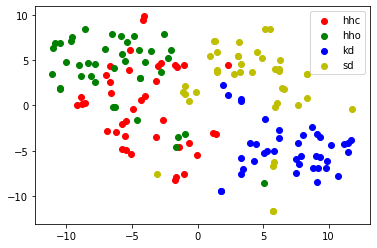

In [11]:
tsne_features_visualize(mfcc_trans, X, y, random_state=42)

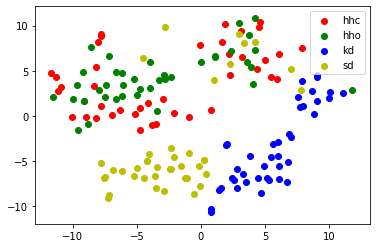

In [12]:
tsne_features_visualize(ctall_trans, X, y, random_state=42)

In [13]:
X2, y2 = fetch_samples(avp_segments_personal, n_per_class=40, random_seed=42)

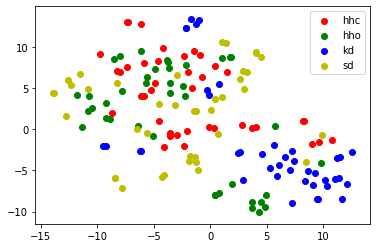

In [14]:
tsne_features_visualize(mfcc_trans, X2, y2, random_state=42)

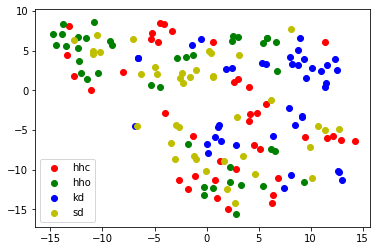

In [15]:
tsne_features_visualize(ctall_trans, X2, y2, random_state=42)

In [16]:
avp_personal_segments = vxs.SimpleSampleSet(glob.glob('../data_temp/avp-cut/personal/*/*.wav'))

In [17]:
X3, y3 = fetch_samples(avp_personal_segments, n_per_class=40, random_seed=42)

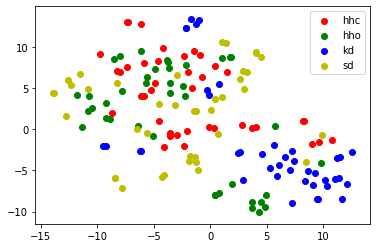

In [18]:
tsne_features_visualize(mfcc_trans, X3, y3, random_state=42)

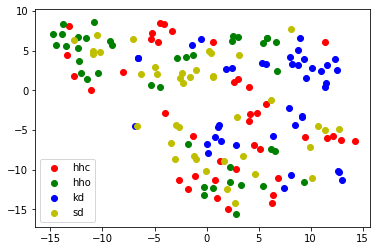

In [19]:
tsne_features_visualize(ctall_trans, X3, y3, random_state=42)

In [26]:
bbset1_segments = vxs.SimpleSampleSet(glob.glob('../data_temp/beatboxset1/DR/*/*.wav'))

In [27]:
len(bbset1_segments)

2317

In [28]:
X4, y4 = fetch_samples(bbset1_segments, n_per_class=40, random_seed=42)

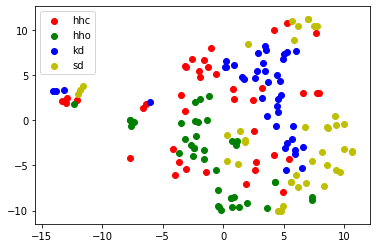

In [29]:
tsne_features_visualize(mfcc_trans, X4, y4, random_state=42)

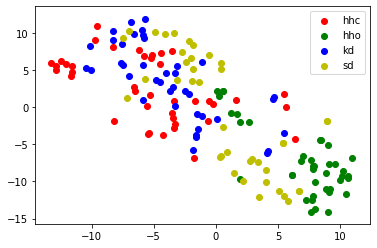

In [30]:
tsne_features_visualize(ctall_trans, X4, y4, random_state=42)

#### Size of an encoder vs size of an input

In [2]:
model_names = ['square-1', 'square-2', 'square-3', 
                  'tall-1', 'tall-2', 'tall-3', 'tall-4', 
                  'wide-1', 'wide-2', 'wide-3', 'wide-4']

cae_models = {
    mtype: vxs.get_CAE_model(mtype, f'../logs/cae-bark-finaldata_65536_{mtype}/checkpoints/best.pth')
    for mtype in model_names
}

In [3]:
def get_output_shapes(model):
    model.eval()
    segm_lens = []
    inp_shapes = []
    out_shapes = []
    z_shapes = []
    for i in [8, 16, 24, 32, 64, 128]:
        inp = torch.randn(1, 1, 128, i)
        outp, z = model(inp)
        inp_shapes.append(inp.shape)
        out_shapes.append(outp.shape)
        z_shapes.append(z.shape)
        
    return inp_shapes, out_shapes, z_shapes
        
inp_shapes, out_shapes, z_shapes = get_output_shapes(cae_models['square-1'])

In [4]:
import vxs.utils as vxsu

cae_groups = {
    'square': ['square-1', 'square-2', 'square-3'],
    'tall': ['tall-1', 'tall-2', 'tall-3', 'tall-4'],
    'wide': ['wide-1', 'wide-2', 'wide-3', 'wide-4']
}
shapes = {}
for group, ms in cae_groups.items():
    for m in ms:
        shapes[m] = get_output_shapes(cae_models[m])

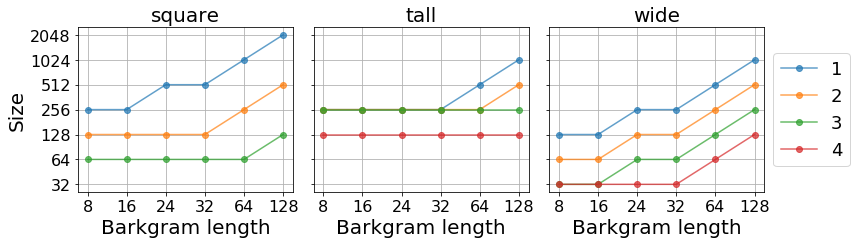

In [5]:
fsize=20
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 3.5), sharex=True, sharey=True)
yticks = np.log2(np.array([32, 64, 128, 256, 512, 1024, 2048]))

for (group, models), ax in zip(cae_groups.items(), axes):
    plt.sca(ax)
    for mname in models:
        inp_shapes, out_shapes, z_shapes = shapes[mname]
        xs = [s[-1] for s in inp_shapes]
        ys = [np.log2(np.product(s)) for s in z_shapes]
        cae_num = mname.split('-')[1]
        plt.plot(np.arange(6), ys, label=cae_num, marker='o', alpha=0.7)

    plt.xticks(ticks=np.arange(6), labels=[8, 16, 24, 32, 64, 128], fontsize=fsize-4)
    plt.yticks(ticks=yticks, labels=(2**yticks).astype(int), fontsize=fsize-4)
    if group == 'square':
        plt.ylabel('Size', fontsize=fsize)
    plt.xlabel('Barkgram length', fontsize=fsize)
    plt.title(f'{group}', fontsize=fsize)
    plt.grid(which='both')
    #ncol = 1 if group == 'square' else 2
    #plt.legend(fontsize=fsize-4, ncol=ncol)
    if group == 'wide':
        plt.legend(fontsize=fsize-2, loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
vxsu.save_plot('caes_timeframes_sizes')
plt.show()

In [20]:
def plot_z_shapes(model_names):
    df = pd.DataFrame(columns=['type', 'sgram_len', 'size'])
    if len(model_names) % 3 == 0:
        cols = 3
        rows = len(model_names) // 3
    else:
        cols = 2
        rows = int(np.ceil(len(model_names) / 2))
        
    fig, axes = plt.subplots(ncols=cols, nrows=rows, 
                             figsize=(cols*5, rows*4), sharex=True)
    
    axes = list(np.array(axes).flatten())
    for (group, models), ax in zip(model_names, axes):
        inp_lens, inp_shapes, out_shapes, z_shapes = get_output_shapes(cae_models[mname])
        xs = np.array(inp_lens) // 4096
        inp_s_lens = [s[-1] for s in inp_shapes]
        ys = [np.product(s) for s in z_shapes]
        print(mname)
        print(np.array(list(zip(inp_lens, inp_s_lens, ys))))
        plt.sca(ax)
        plt.plot(xs, ys)
        plt.xticks(xs)
        plt.yticks(ys)
        plt.ylabel('Size of representation')
        plt.xlabel('Barkgram time frames')
        plt.title(f'Hidden representation size ({mname})')
        plt.grid(which='both')
        
    plt.show()

square-1
[[ 4096     8   256]
 [ 8192    16   256]
 [12288    24   512]
 [16384    32   512]
 [20480    40   768]
 [24576    48   768]
 [28672    56  1024]
 [32768    64  1024]
 [36864    72  1280]
 [40960    80  1280]
 [45056    88  1536]
 [49152    96  1536]
 [53248   104  1792]
 [57344   112  1792]
 [61440   120  2048]
 [65536   128  2048]]
square-2
[[ 4096     8   128]
 [ 8192    16   128]
 [12288    24   128]
 [16384    32   128]
 [20480    40   256]
 [24576    48   256]
 [28672    56   256]
 [32768    64   256]
 [36864    72   384]
 [40960    80   384]
 [45056    88   384]
 [49152    96   384]
 [53248   104   512]
 [57344   112   512]
 [61440   120   512]
 [65536   128   512]]
square-3
[[ 4096     8    64]
 [ 8192    16    64]
 [12288    24    64]
 [16384    32    64]
 [20480    40    64]
 [24576    48    64]
 [28672    56    64]
 [32768    64    64]
 [36864    72   128]
 [40960    80   128]
 [45056    88   128]
 [49152    96   128]
 [53248   104   128]
 [57344   112   128]
 [614

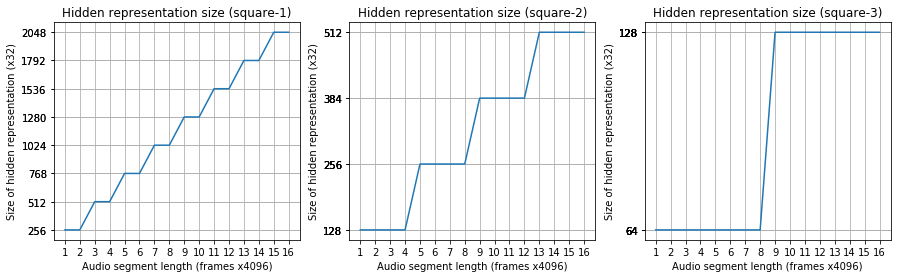

In [21]:
plot_z_shapes(['square-1', 'square-2', 'square-3'])

12288 torch.Size([1, 1, 128, 24]) torch.Size([1, 32, 8, 1])
12288 torch.Size([1, 1, 128, 24]) torch.Size([1, 32, 8, 1])
12288 torch.Size([1, 1, 128, 24]) torch.Size([1, 32, 8, 1])
12288 torch.Size([1, 1, 128, 24]) torch.Size([1, 32, 4, 1])


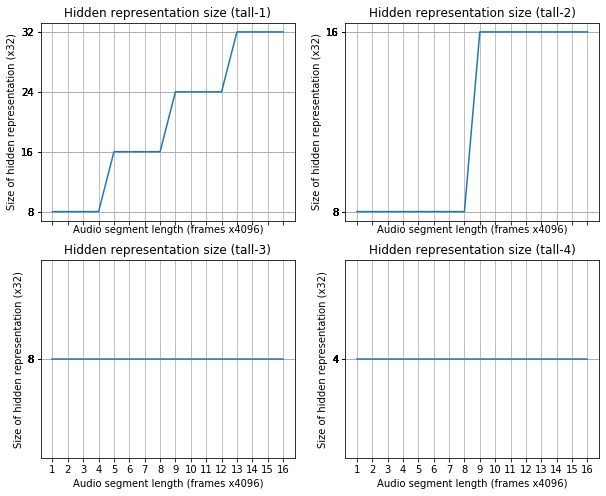

In [52]:
plot_z_shapes(['tall-1', 'tall-2', 'tall-3', 'tall-4'])

12288 torch.Size([1, 1, 128, 24]) torch.Size([1, 32, 4, 2])
12288 torch.Size([1, 1, 128, 24]) torch.Size([1, 32, 2, 2])
12288 torch.Size([1, 1, 128, 24]) torch.Size([1, 32, 1, 2])
12288 torch.Size([1, 1, 128, 24]) torch.Size([1, 32, 1, 1])


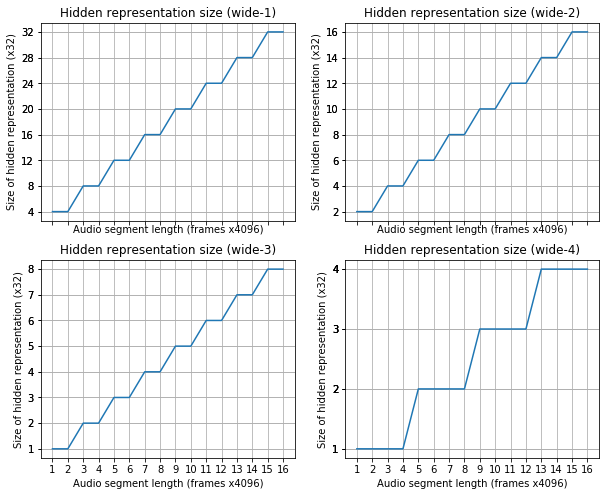

In [53]:
plot_z_shapes(['wide-1', 'wide-2', 'wide-3', 'wide-4'])

In [15]:
tensor = torch.tensor(np.random.rand(128, 4)).unsqueeze(0)
tensor.shape

In [8]:
torch.random?

Type:        module
String form: <module 'torch.random' from '/home/ubuntu/Research/msc_dissertation_vpt/vxs-vpt/pythonenv/lib/python3.6/site-packages/torch/random.py'>
File:        ~/Research/msc_dissertation_vpt/vxs-vpt/pythonenv/lib/python3.6/site-packages/torch/random.py
Docstring:   <no docstring>
